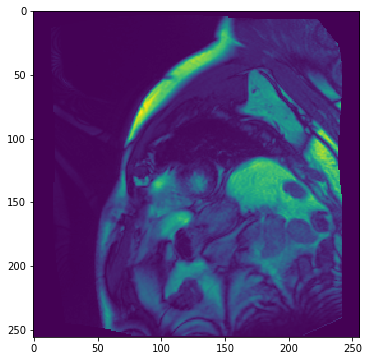

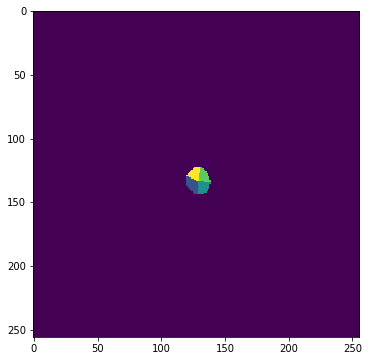

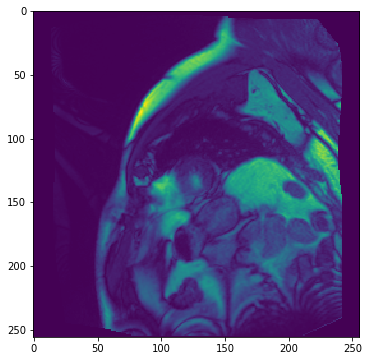

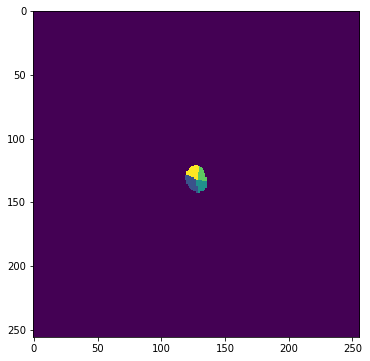

330
330
(330, 256, 256) (330, 256, 256)


In [1]:
%matplotlib inline

import dicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from glob import glob

dsb_path = "/home/ammiadmin/Downloads/data/kaggle_dsb/1/study/"
label_path = "/home/ammiadmin/Downloads/data/regional_label_np/train/1/study/"
subdirs = glob(label_path + '/*/')
labels = []
images = []

side_crop = 0


for subdir in subdirs:
    images_path = glob(subdir + '/*.npy')
    for image_path in images_path:
        dicom_end_path = image_path[image_path.rfind('/study/') + len('/study/'):image_path.rfind('.npy')]
        dc = dicom.read_file(dsb_path + dicom_end_path + '.dcm')
        image = dc.pixel_array
        image = image[side_crop:image.shape[0] - side_crop, side_crop:image.shape[1] - side_crop]
        
        pad = np.zeros((256, 13), dtype=np.int32)
        image = np.concatenate((pad, image, pad), axis=1)
        
        images.append(image)
#         img=mpimg.imread(image_path)
#         img = img.copy()
        img = np.load(image_path)
        img = img[side_crop:img.shape[0] - side_crop, side_crop:img.shape[1] - side_crop]
        
        pad = np.zeros((256, 13), dtype=np.int32)
        img = np.concatenate((pad, img, pad), axis=1)
        
        img[img < 20] = 0
        img[(img >= 20) & (img < 40)] = 1
        img[(img >= 40) & (img < 60)] = 2
        img[(img >= 60) & (img < 80)] = 3
        img[(img >= 80) & (img < 100)] = 4
        img[(img >= 100) & (img < 120)] = 5
        img[img >= 120] = 6
        
        labels.append(img)

for i in range(2):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.imshow(images[i])
    plt.show()
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.imshow(labels[i])
    plt.show()
print(len(images))
print(len(labels))

# np.set_printoptions(threshold=np.nan)
# print(labels[0][120:140, 100:130])

# fig, ax = plt.subplots(figsize=(10, 8))
# plt.imshow(labels[100])
# print(labels[100][40:80, 55:70])

X = np.rollaxis(np.dstack(images), -1)
Y = np.rollaxis(np.dstack(labels), -1)
print(X.shape, Y.shape)

In [2]:
import keras.backend as K

batch_size = 16
num_classes = 7 # per pixel

# input image dimensions
img_rows, img_cols = X.shape[1], X.shape[2]

# the data, shuffled and split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# WTF did I do here?? shuffle separately????
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

x_train = X[:280]
x_test = X[280:]
y_train = Y[:280]
y_test = Y[280:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train_one_hot = np.zeros([y_train.shape[0], y_train.shape[1], y_train.shape[2], num_classes])
y_test_one_hot = np.zeros([y_test.shape[0], y_test.shape[1], y_test.shape[2], num_classes])

# one-hotize
for instance_index in range(y_train.shape[0]):
    for row_ind in range(y_train.shape[1]):
        for col_ind in range(y_train.shape[2]):
            pixel_label = y_train[instance_index, row_ind, col_ind]
            y_train_one_hot[instance_index, row_ind, col_ind, pixel_label] = 1
            # we don't care about classifying background.. otherwise it will yield high dice score
#             if pixel_label != 0:
#                 y_train_one_hot[instance_index, row_ind, col_ind, pixel_label - 1] = 1

for instance_index in range(y_test.shape[0]):
    for row_ind in range(y_test.shape[1]):
        for col_ind in range(y_test.shape[2]):
            pixel_label = y_test[instance_index, row_ind, col_ind]
            y_test_one_hot[instance_index, row_ind, col_ind, pixel_label] = 1
#             if pixel_label != 0:
#                 y_test_one_hot[instance_index, row_ind, col_ind, pixel_label - 1] = 1


print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print('x_train shape:', x_train.shape)
print('y_train_one_hot shape:', y_train_one_hot.shape)
print(y_train[100, 70, 60])
print(y_train_one_hot[100, 70, 60, :])

Using TensorFlow backend.


280 train samples
50 test samples
x_train shape: (280, 256, 256, 1)
y_train_one_hot shape: (280, 256, 256, 7)
0
[ 1.  0.  0.  0.  0.  0.  0.]


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 12

import json

import numpy as np

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage as ndi

# import nibabel as nib

import tensorflow as tf
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.layers import Conv2D, Input
from keras.layers import Reshape, Dropout
from keras.layers import RepeatVector
from keras.layers import Activation, BatchNormalization
from keras.layers import concatenate, GlobalAveragePooling2D
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

from ipywidgets import interact
import ipywidgets as widgets

print(K.image_data_format())

smooth_factor = 1.0

CROP_WIDTH = x_train.shape[2]
CROP_HEIGHT = x_train.shape[1]

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth_factor) / \
           (K.sum(y_true_f) + K.sum(y_pred_f) + smooth_factor)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def my_weighted_loss(onehot_labels, logits):

    # compute weights based on their frequencies
    class_weights = [0.1, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0] # set your class weights here
    # computer weights based on onehot labels
    weights = tf.reduce_sum(class_weights * onehot_labels, axis=-1)
    # compute (unweighted) softmax cross entropy loss
    unweighted_losses = tf.nn.softmax_cross_entropy_with_logits(labels=[onehot_labels], logits=[logits])
    # apply the weights, relying on broadcasting of the multiplication
    weighted_losses = unweighted_losses * weights
    # reduce the result to get your final loss
    loss = tf.reduce_mean(weighted_losses)
    return loss

def get_unet():
    inputs = Input((CROP_HEIGHT, CROP_WIDTH, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = get_unet()
opt = Adam(lr=0.001)

model.compile(optimizer=opt,
              loss=my_weighted_loss,
              metrics=["accuracy"])

# model.compile(optimizer=opt,
#               loss=dice_coef_loss,
#               metrics=["accuracy"])

# model.compile(optimizer=opt,
#               loss=keras.losses.categorical_crossentropy,
#               metrics=["accuracy"])

model.summary()

channels_last
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
_______________________________________________________________________________________________

In [ ]:
model.fit(x_train, y_train_one_hot,
          batch_size=16, epochs=100, verbose=2, validation_data=(x_test, y_test_one_hot))

Train on 280 samples, validate on 50 samples
Epoch 1/100
 - 8s - loss: 0.4107 - acc: 0.9198 - val_loss: 0.3759 - val_acc: 0.9880
Epoch 2/100
 - 4s - loss: 0.3918 - acc: 0.9872 - val_loss: 0.3759 - val_acc: 0.9880
Epoch 3/100
 - 4s - loss: 0.3918 - acc: 0.9872 - val_loss: 0.3759 - val_acc: 0.9880
Epoch 4/100
 - 4s - loss: 0.3918 - acc: 0.9872 - val_loss: 0.3759 - val_acc: 0.9880
Epoch 5/100
 - 4s - loss: 0.3918 - acc: 0.9872 - val_loss: 0.3759 - val_acc: 0.9880
Epoch 6/100


In [ ]:
from sklearn.metrics import f1_score

all_dice = []

sample_output = model.predict_on_batch(x_test)
print(sample_output.shape)
print(sum(sample_output[1, 30, 20, :]))

for i in range(sample_output.shape[0]):
    pred_image = sample_output[i]
#     print(pred_image.shape)
    visualize = np.zeros([pred_image.shape[0], pred_image.shape[1]])

    for row_ind in range(visualize.shape[0]):
        for col_ind in range(visualize.shape[1]):
            visualize[row_ind, col_ind] = np.argmax(pred_image[row_ind, col_ind, :])
#             if max(pred_image[row_ind, col_ind, :]) > 0.99:
#                 visualize[row_ind, col_ind] = np.argmax(pred_image[row_ind, col_ind, :]) + 1
#             else:
#                 visualize[row_ind, col_ind] = 0
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 8))
    ax[0].imshow(x_test[i, :, :, 0])
    ax[1].imshow(y_test[i, :, :])
    ax[2].imshow(visualize)
    true_flat = y_test[i, :, :].flatten()
    pred_flat = visualize.flatten()
    y_true = []
    y_pred = []
    true_non_bg_pixels = 0
    pred_non_bg_pixels = 0
    intersection_non_bg = 0
    for ind in range(true_flat.shape[0]):
        if true_flat[ind] != 0: # if pixel is not background then we care
            true_non_bg_pixels += 1
        if pred_flat[ind] != 0:
            pred_non_bg_pixels += 1
        if true_flat[ind] != 0 and pred_flat[ind] != 0 and true_flat[ind] == pred_flat[ind]:
            intersection_non_bg += 1
    sample_dice = 2 * intersection_non_bg / (true_non_bg_pixels + pred_non_bg_pixels)
#     sample_f1 = f1_score(y_true, y_pred, average='macro')
#     print(sample_f1)
    all_dice.append(sample_dice)
#     fig, ax = plt.subplots(figsize=(8, 6))
    
# print(labels[100][40:80, 55:70])
# fig, ax = plt.subplots(figsize=(10, 8))
# plt.imshow(x_test[0, :, :, 0])
print("avg dice score: " + str(np.mean(all_dice)))
score = model.evaluate(x_test, y_test_one_hot, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])